# Perform Classification on the ADNI dataset using Bagging:

## Importing stuff:

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

## Read the Data:

In [2]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_csv("./DATA/Linearly_Transformed_Unique_Dataset.csv")
print(lr_data.shape)
lr_data.head()

(1302, 210)


,Unnamed: 0,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,...,1,1,1,0,0,0,0,0,1,0
1,9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,...,0,1,1,0,1,0,0,0,0,0
2,24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,...,0,0,0,0,1,0,0,0,0,0
3,31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,...,0,0,0,1,1,0,0,0,2,1
4,45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,...,0,0,0,1,1,0,0,0,1,2


In [3]:
mca_data = np.load("./DATA/MCA_Transformed_Genetic_data_10_components.pkl.npy")
print(mca_data.shape)
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = genetic_columns
print("Before: ",lr_data.shape)
mca = lr_data.drop(labels = columns_to_drop, axis=1)

# Embed them into the new dataset:
component_labels = ["component_"+str(x+1) for x in range(mca_data.shape[1])] 
mca[component_labels] = mca_data
print("After: ",mca.shape)
mca.head()

(1302, 10)
Before:  (1302, 210)
After:  (1302, 166)


,Unnamed: 0,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,...,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,...,0.023717,0.007582,0.031241,-0.002605,0.021999,-0.002884,0.013514,0.020076,-0.033714,0.023457
1,9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,...,0.010519,-0.029121,-0.024141,0.002656,-0.018639,-0.021598,-0.009398,-0.038362,0.019414,0.051440
2,24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,...,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
3,31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,...,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
4,45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,...,-0.004070,-0.009009,0.018683,0.034929,0.039583,-0.002678,-0.030461,-0.027636,-0.024174,0.028044


In [4]:
# Weird errors silencing when creating the new dataframe:
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::RuntimeWarning')
    
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/MCA_DCCA_outputs.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head()

Transformed imaging data dimensions: 
 (1302, 150)
Transformed genetic data dimensions: 
 (1302, 150)
DCCA Data Dimensions: 
 (1302, 311)


,Unnamed: 0,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,...,imaging_component_141,imaging_component_142,imaging_component_143,imaging_component_144,imaging_component_145,imaging_component_146,imaging_component_147,imaging_component_148,imaging_component_149,imaging_component_150
0,0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,...,0.991986,-15.197325,13.987051,0.280044,-14.724760,6.037100,15.896213,9.093044,-12.119327,-9.300970
1,9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,...,0.434874,-15.113810,13.904093,1.522299,-15.769327,5.156594,15.363470,9.554826,-11.601482,-6.403308
2,24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,...,1.177222,-14.891131,12.314053,1.644624,-15.767372,5.532053,12.083865,12.130998,-11.517179,-10.742541
3,31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,...,1.815794,15.584515,-12.341055,-0.648647,18.520105,-12.481134,-20.515711,-13.690228,11.798060,14.365234
4,45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,...,0.751206,-13.202568,13.106786,2.910506,-17.922320,5.856430,12.711363,10.478322,-8.806449,-5.748745


## Defining helper functions:

In [6]:
def perform_classification(X_train, X_test, Y_train, Y_test, model, params):
    # Performing Grid Search and Cross Validation in order to find the best combination of parameters:
    clf = GridSearchCV(model, params, n_jobs=-1, cv=5)
    clf.fit(X_train,Y_train)
    # Finding the best classifier's prediction, and then computing the metrics. 
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    bal_acc = balanced_accuracy_score(Y_test, pred)
    print("Best Parameters:",clf.best_params_)
    return acc, f1, bal_acc, np.around(cm, decimals=2), clf.best_params_

def barplot_scores(Accuracies, F1s, Bal_Accuracies, Names):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8), dpi=600)
    
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
    
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    plt.bar(br3, [100*x for x in Bal_Accuracies], color ='g', width = barWidth, edgecolor ='grey', label ='Balanced Accuracy')
    
    plt.xlabel('Classifier', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy Score (%)', fontweight ='bold', fontsize = 15)
    
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names, rotation=45)
    plt.grid()
    plt.legend(prop={'size': 7})
    plt.show()
    return

def confusion_matrices(Confusion_Matrices, names, n_rows=2, n_cols=3):
    fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(22,22));
    sns.set(font_scale=1) # for label size
    
    # No DCCA:
    for i in range(len(names)):
        row, col = i // n_cols, i % n_cols
        ytick = False
        xtick = False

        if col == 0:
            ytick = ["CN", "AD", "MCI"]
        if row == n_rows - 1:
            xtick = ["CN", "AD", "MCI"]
            
        sns.heatmap(Confusion_Matrices[i], annot=True, annot_kws={"size": 16}, ax = axes[row][col], fmt='g',
                   xticklabels = xtick, yticklabels = ytick).set_title(names[i])
            
    plt.show()
    return

def undersample(df, ylabel='Diagnosis_nearest_2.0'):
    classes = df[ylabel].value_counts().to_dict() # specific to this dataset
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[ylabel] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

## Perform Classification using Bagging:

In [7]:
# Defining the Bagging model, as well as the model parameters for the Grid Search:
model1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True,bootstrap_features=False, max_features=1.0, n_jobs=-1)
params1 = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'base_estimator__criterion': ["gini", "entropy"],    
    'base_estimator__max_depth': [1,2,5]
}

# Defining the Bagging model, as well as the model parameters for the Grid Search:
model2 = BaggingClassifier(base_estimator=LinearSVC(), bootstrap=True,bootstrap_features=False, max_features=1.0, n_jobs=-1)
params2 = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'base_estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# The different trial names (for saving the best parameters if needed):
names = ['Both without DCCA DT',    'Both without DCCA SVM',
         'Both with DCCA DT',       'Both with DCCA SVM',
         'Imaging without DCCA DT', 'Imaging without DCCA SVM',
         'Imaging with DCCA DT',    'Imaging with DCCA SVM',
         'Genetic without DCCA DT', 'Genetic without DCCA SVM',
         'Genetic with DCCA DT',    'Genetic with DCCA SVM']

# Saving the metrics and the Confusion Matrices, as well as the best parameter combinations:
Accuracies = []
F1s = []
Balanced_Accuracies = []
Confusion_Matrices = []
Best_parameter_combinations = []

##############################################################################  IMAGING + MCA GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = mca[MRI_columns + component_labels]
Y = mca["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

############################################################################## IMAGING + MCA GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = mca[MRI_columns]
Y = mca["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

##############################################################################  MCA GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = mca[component_labels]
Y = mca["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

############################################################################## MCA GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


print("#############################")
Trial_info = []
for i in range(len(names)):
    Trial_info.append([Accuracies[i],
                       F1s[i],
                       Balanced_Accuracies[i],
                       Confusion_Matrices[i],
                       Best_parameter_combinations[i]])
    print()
    print("For trial ", names[i],":")
    print("Accuracy:          ", round(Accuracies[i]*100,2))
    print("F1 score:          ", round(F1s[i]*100,2))
    print("Balanced Accuracy: ", round(Balanced_Accuracies[i]*100,2))

print()
print("#############################")

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
DT
Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'max_samples': 0.8, 'n_estimators': 15}
SVM
Best Parameters: {'base_estimator__C': 0.0001, 'max_samples': 0.6, 'n_estimators': 15}
#################### IMAGING + GENETIC DCCA: ####################
DT
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 2, 'max_samples': 1.0, 'n_estimators': 5}
SVM
Best Parameters: {'base_estimator__C': 0.001, 'max_samples': 1.0, 'n_estimators': 15}
#################### IMAGING: ####################
DT
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 2, 'max_samples': 0.6, 'n_estimators': 15}
SVM
Best Parameters: {'base_estimator__C': 1e-05, 'max_samples': 0.6, 'n_estimators': 15}
#################### IMAGING DCCA: ####################
DT
Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'max_sampl

### Visualize the results:

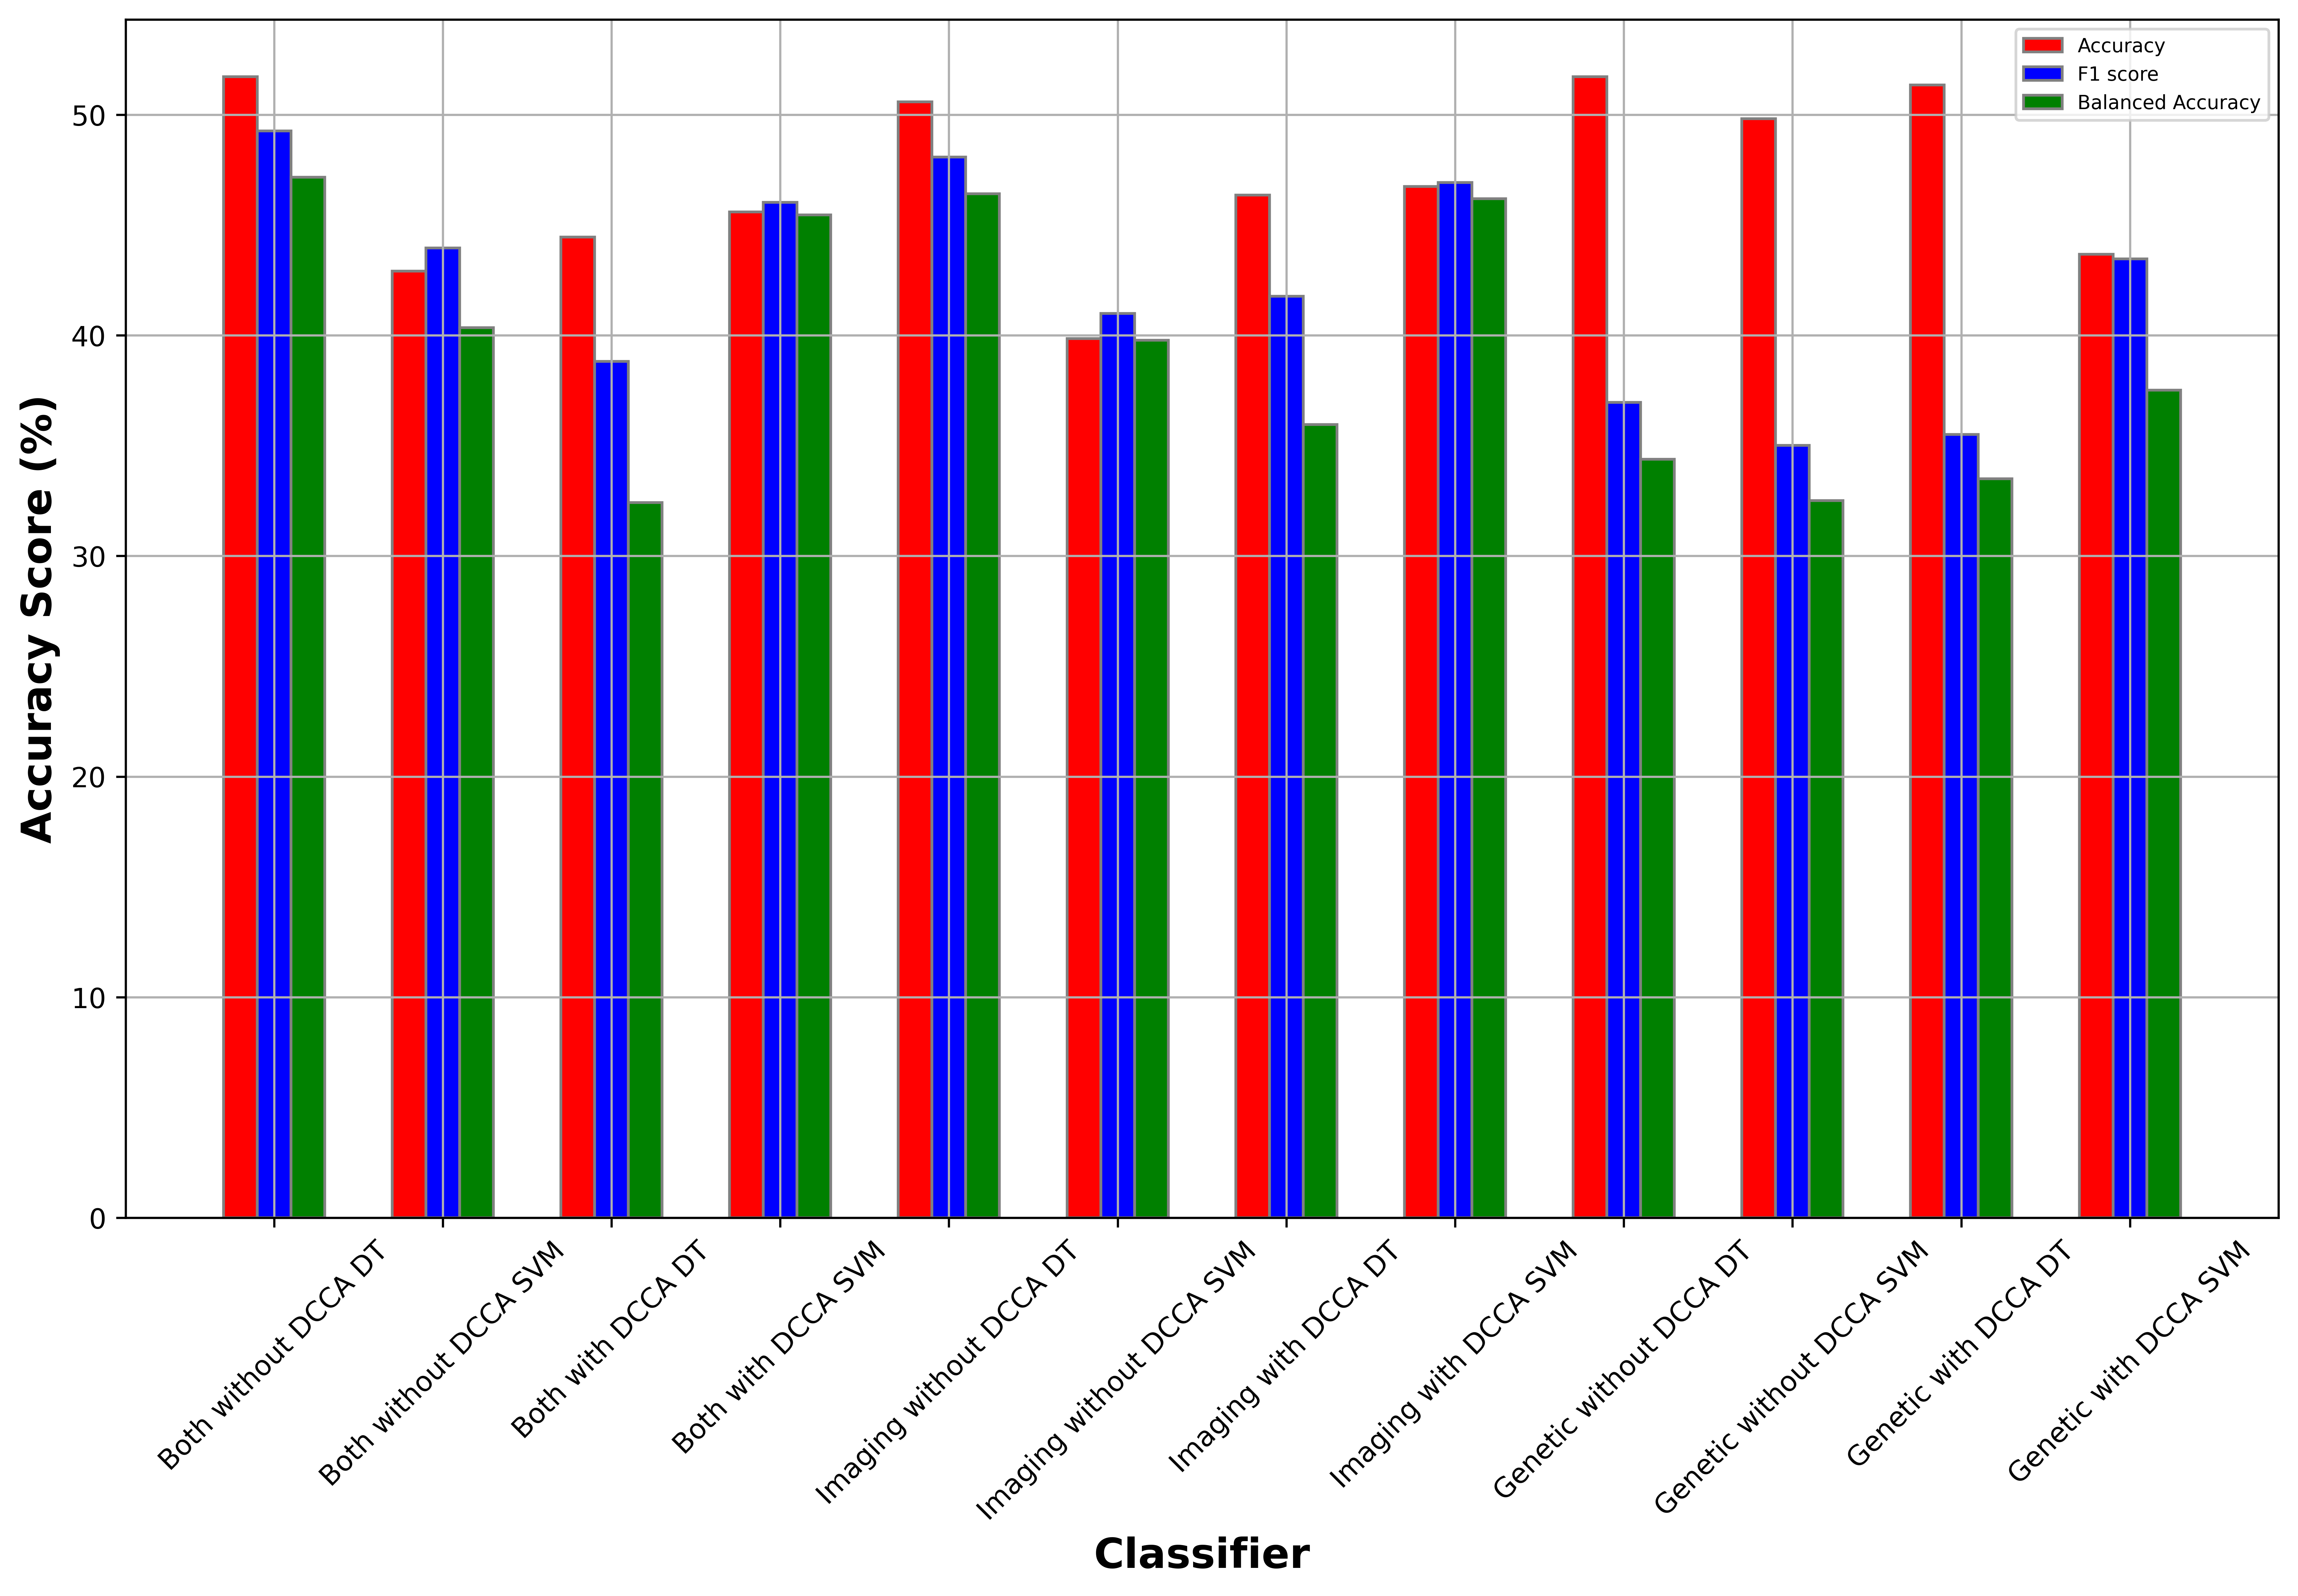

In [8]:
barplot_scores(Accuracies, F1s, Balanced_Accuracies, names)

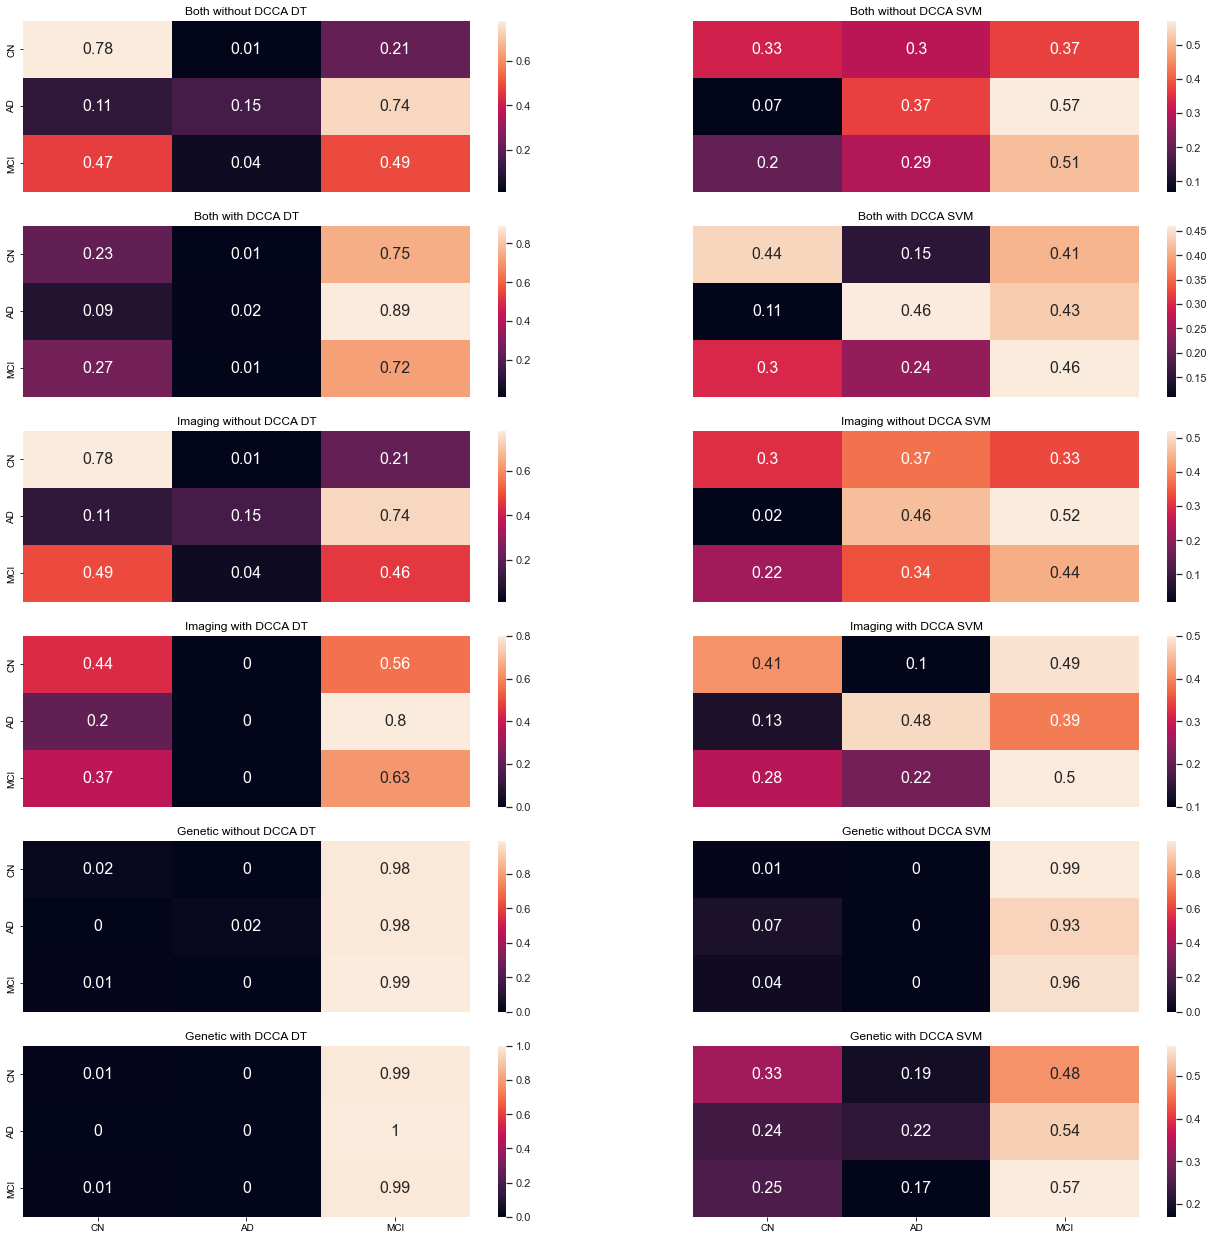

In [9]:
confusion_matrices(Confusion_Matrices, names, n_rows=6, n_cols=2)

## Scaling and Balancing:

In [10]:
# Scale the data:
scaler = preprocessing.StandardScaler()
mca_scaled = scaler.fit_transform(mca[MRI_columns])
mca[MRI_columns] = mca_scaled

# Balance the data through Undersampling:
mca_usampled = undersample(mca)
mca_usampled = mca_usampled.sort_values('PTID', ascending=True)
mca_usampled.reset_index(drop=True, inplace=True)

print(mca_usampled['Diagnosis_nearest_2.0'].value_counts())
print(mca_usampled.shape)

mca = mca_usampled
print(mca.shape)
mca.head()

CN          243
Dementia    243
MCI         243
Name: Diagnosis_nearest_2.0, dtype: int64
(729, 166)
(729, 166)


,Unnamed: 0,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,...,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,...,0.003137,0.020240,0.030544,0.036016,0.083296,0.002379,-0.020733,-0.015252,-0.012902,0.034174
1,31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,...,-0.047720,-0.001291,-0.025738,0.033784,-0.058591,0.001219,0.015067,-0.026107,0.044011,0.042946
2,64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,...,0.038518,-0.028622,0.003513,0.046327,-0.024738,0.000350,0.008199,0.013520,0.002055,0.038282
3,69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,...,-0.037936,-0.005529,0.038916,0.010216,0.001769,0.033678,0.030277,0.049500,-0.011263,-0.043186
4,74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,...,0.015300,0.011375,-0.021789,-0.024325,0.031788,0.004418,0.061140,0.088310,-0.064144,0.011162


In [11]:
# Scale the data:
scaler = preprocessing.StandardScaler()
dcca_data_scaled = scaler.fit_transform(dcca_data[imaging_labels])

dcca_data[imaging_labels] = dcca_data_scaled
dcca_data[genetic_labels].head()
# Balance the data through Undersampling - Use the same indexes as the LR Data:
dcca_data = dcca_data.loc[dcca_data['PTID'].isin(lr_data['PTID'])]
dcca_data_usampled = undersample(dcca_data)
dcca_data_usampled = dcca_data_usampled.sort_values('PTID', ascending=True)
dcca_data_usampled.reset_index(drop=True, inplace=True)

print(dcca_data_usampled['Diagnosis_nearest_2.0'].value_counts())
print(dcca_data_usampled.shape)

dcca_data = dcca_data_usampled
print(dcca_data.shape)
dcca_data.head()

CN          243
Dementia    243
MCI         243
Name: Diagnosis_nearest_2.0, dtype: int64
(729, 311)
(729, 311)


,Unnamed: 0,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,...,imaging_component_141,imaging_component_142,imaging_component_143,imaging_component_144,imaging_component_145,imaging_component_146,imaging_component_147,imaging_component_148,imaging_component_149,imaging_component_150
0,0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,...,0.285303,-1.322700,1.113954,0.017703,-1.108379,0.950037,1.220310,1.010109,-1.313687,-1.506058
1,9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,...,0.135458,-1.315507,1.107375,0.132013,-1.184913,0.816865,1.179632,1.060127,-1.258410,-1.042286
2,31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,...,0.506879,1.328711,-0.973814,-0.067754,1.327412,-1.850755,-1.559940,-1.457648,1.239372,2.281727
3,45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,...,0.220541,-1.150881,1.044151,0.259753,-1.342659,0.922712,0.977129,1.160155,-0.960054,-0.937523
4,64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,...,0.013912,-1.181937,0.987142,0.140015,-1.217194,0.678287,1.119570,1.238970,-1.064205,-0.903123


In [12]:
# Defining the Bagging model, as well as the model parameters for the Grid Search:
model1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True,bootstrap_features=False, max_features=1.0, n_jobs=-1)
params1 = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'base_estimator__criterion': ["gini", "entropy"],    
    'base_estimator__max_depth': [1,2,5]
}

# Defining the Bagging model, as well as the model parameters for the Grid Search:
model2 = BaggingClassifier(base_estimator=LinearSVC(), bootstrap=True,bootstrap_features=False, max_features=1.0, n_jobs=-1)
params2 = {
    'n_estimators': [5, 10, 15],
    'max_samples' : [0.6, 0.8, 1.0],
    'base_estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# The different trial names (for saving the best parameters if needed):
names = ['Both without DCCA DT',    'Both without DCCA SVM',
         'Both with DCCA DT',       'Both with DCCA SVM',
         'Imaging without DCCA DT', 'Imaging without DCCA SVM',
         'Imaging with DCCA DT',    'Imaging with DCCA SVM',
         'Genetic without DCCA DT', 'Genetic without DCCA SVM',
         'Genetic with DCCA DT',    'Genetic with DCCA SVM']

# Saving the metrics and the Confusion Matrices, as well as the best parameter combinations:
Accuracies = []
F1s = []
Balanced_Accuracies = []
Confusion_Matrices = []
Best_parameter_combinations = []

##############################################################################  IMAGING + MCA GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = mca[MRI_columns + component_labels]
Y = mca["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

############################################################################## IMAGING + MCA GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = mca[MRI_columns]
Y = mca["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)


############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

##############################################################################  MCA GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = mca[component_labels]
Y = mca["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

############################################################################## MCA GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=42)

print("DT")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model1, params1)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("SVM")
acc, f1, bal_acc, cm, best_pars = perform_classification(X_train, X_test, Y_train, Y_test, model2, params2)

Accuracies.append(acc)
F1s.append(f1)
Balanced_Accuracies.append(bal_acc)
Confusion_Matrices.append(cm)
Best_parameter_combinations.append(best_pars)

print("#############################")
Trial_info = []
for i in range(len(names)):
    Trial_info.append([Accuracies[i],
                       F1s[i],
                       Balanced_Accuracies[i],
                       Confusion_Matrices[i],
                       Best_parameter_combinations[i]])
    print()
    print("For trial ", names[i],":")
    print("Accuracy:          ", round(Accuracies[i]*100,2))
    print("F1 score:          ", round(F1s[i]*100,2))
    print("Balanced Accuracy: ", round(Balanced_Accuracies[i]*100,2))

print()
print("#############################")

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))
max_bal_acc = np.argmax(Balanced_Accuracies)
print("Model with max Balanced Accuracy Score: ", names[max_bal_acc], " with a Balanced Accuracy Score of ", round(max(Balanced_Accuracies)*100,3))

#################### IMAGING + GENETIC: ####################
DT
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 5, 'max_samples': 0.6, 'n_estimators': 15}
SVM
Best Parameters: {'base_estimator__C': 0.001, 'max_samples': 0.8, 'n_estimators': 10}
#################### IMAGING + GENETIC DCCA: ####################
DT
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 1, 'max_samples': 1.0, 'n_estimators': 15}
SVM
Best Parameters: {'base_estimator__C': 0.0001, 'max_samples': 0.6, 'n_estimators': 10}
#################### IMAGING: ####################
DT
Best Parameters: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 2, 'max_samples': 0.6, 'n_estimators': 15}
SVM
Best Parameters: {'base_estimator__C': 0.001, 'max_samples': 0.8, 'n_estimators': 5}
#################### IMAGING DCCA: ####################
DT
Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 5, 'max_sa

### Visualize the results:

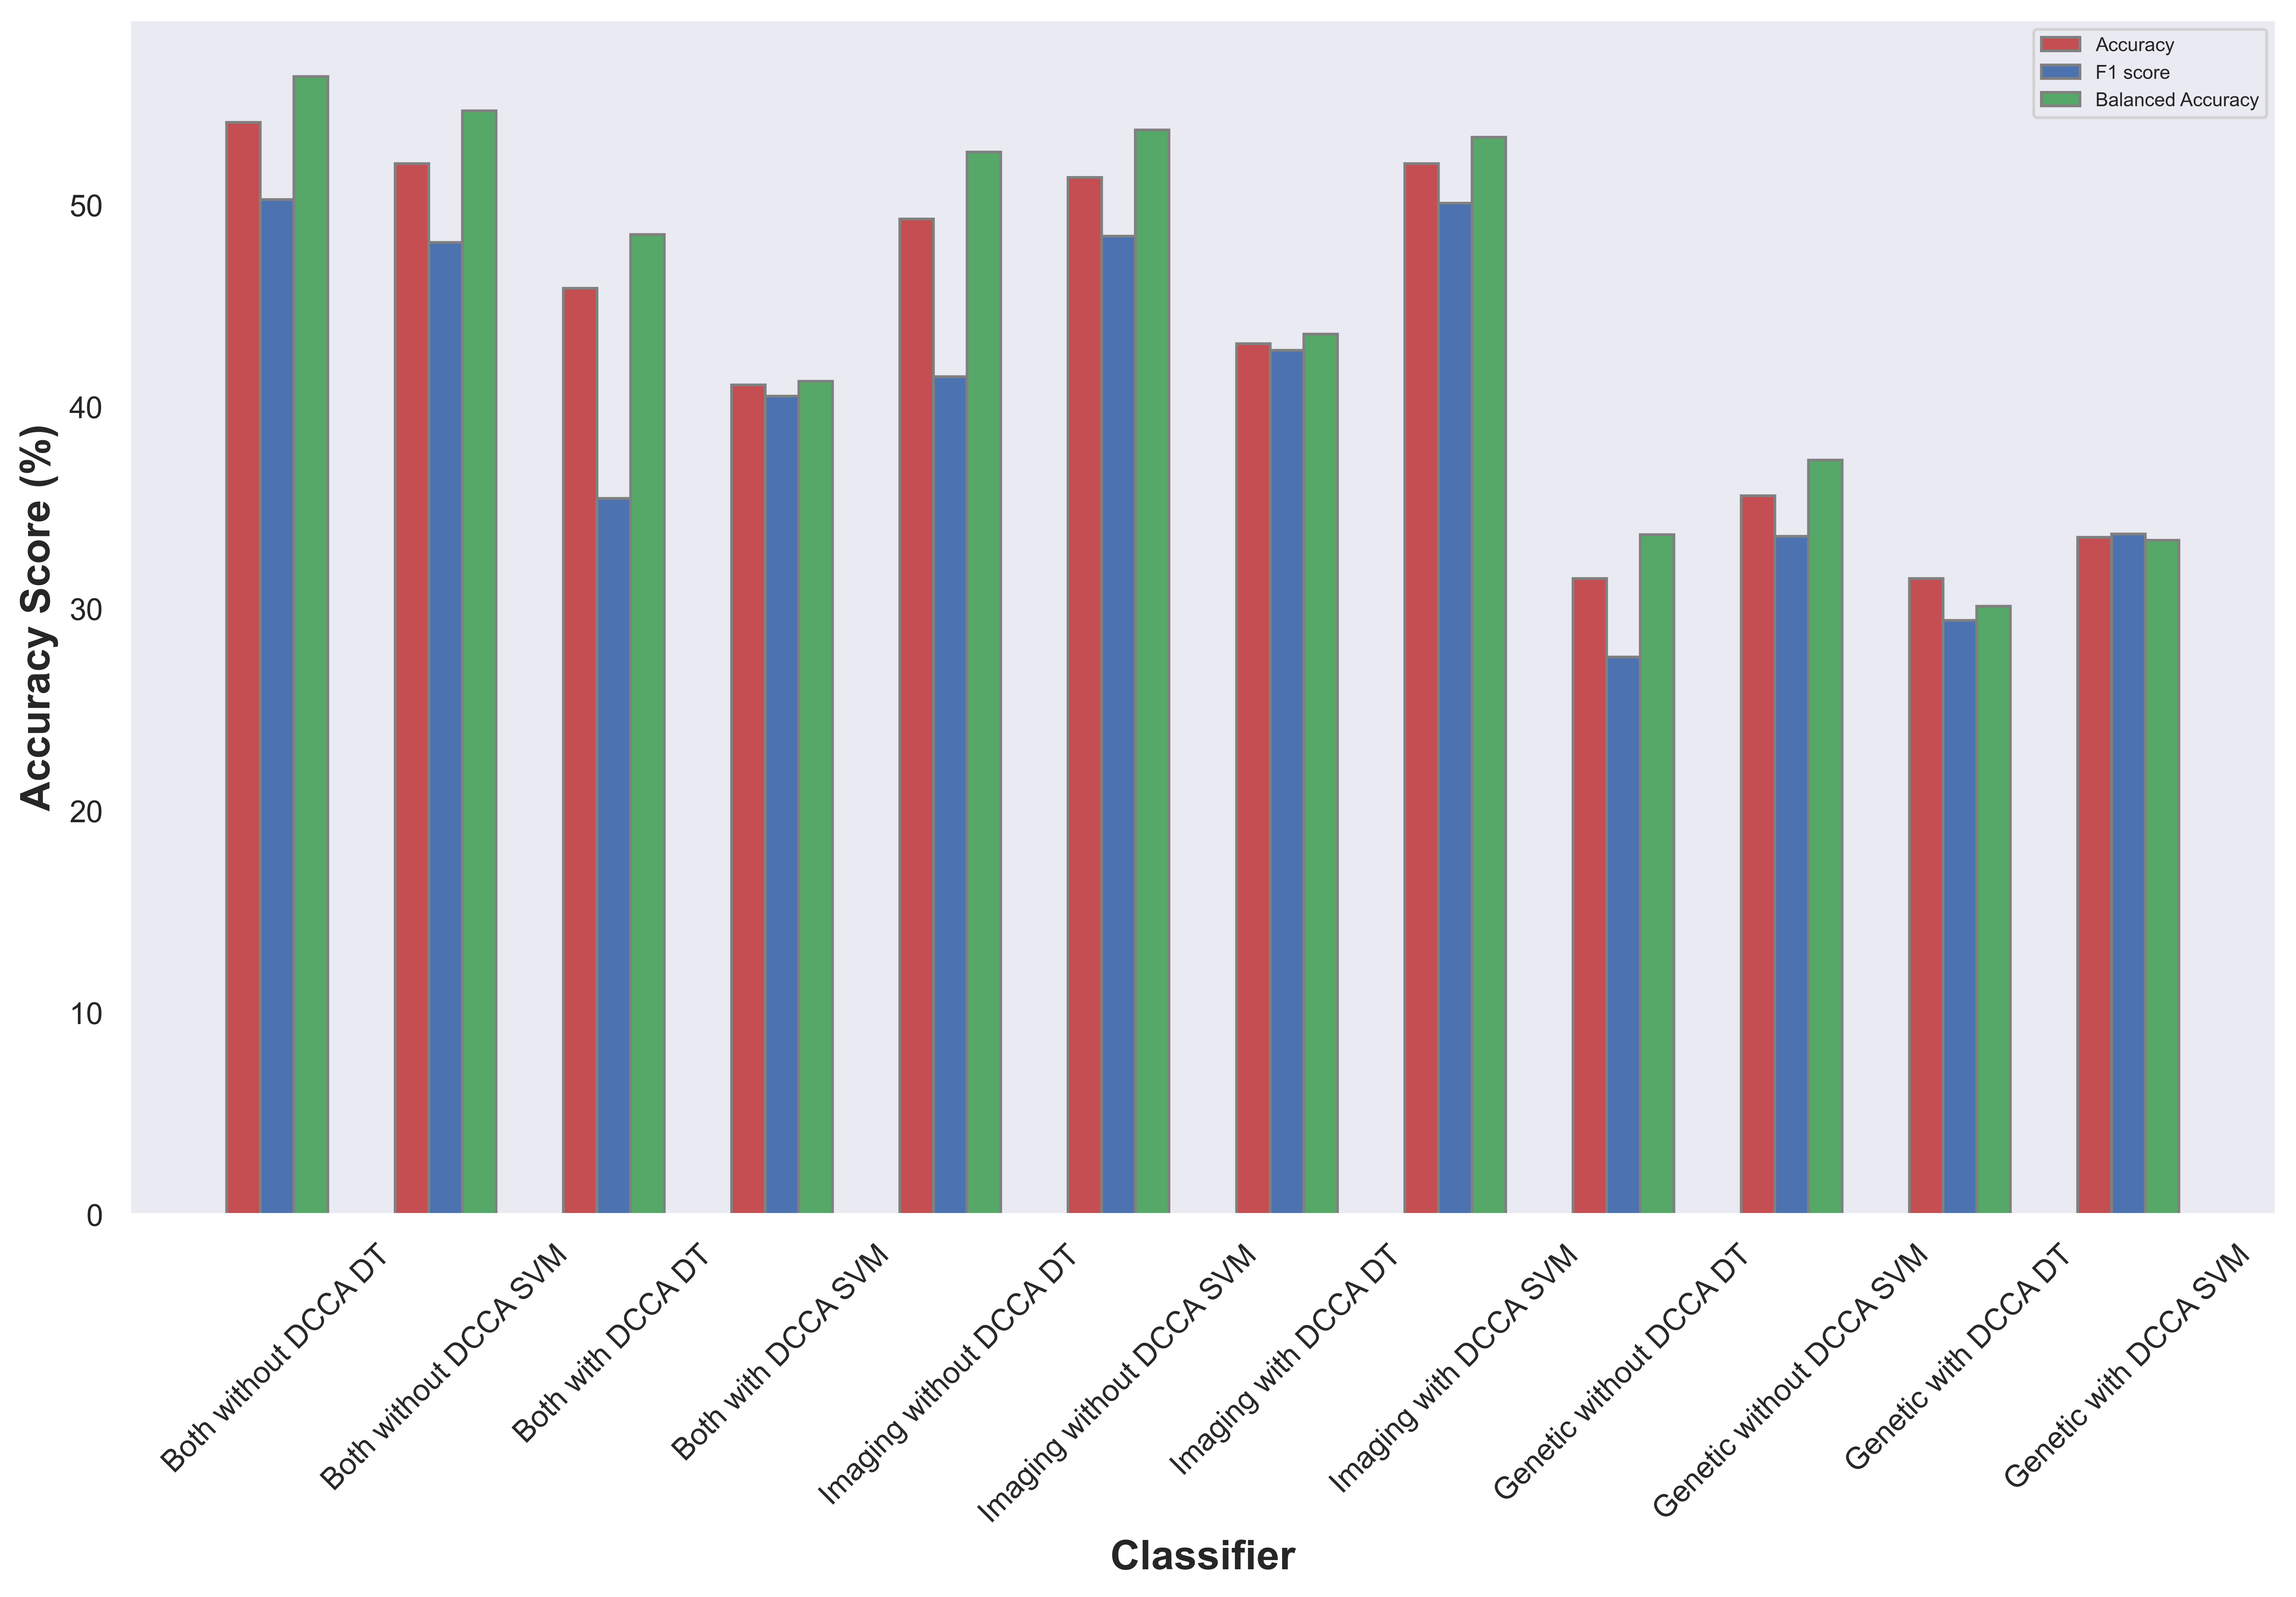

In [13]:
barplot_scores(Accuracies, F1s, Balanced_Accuracies, names)

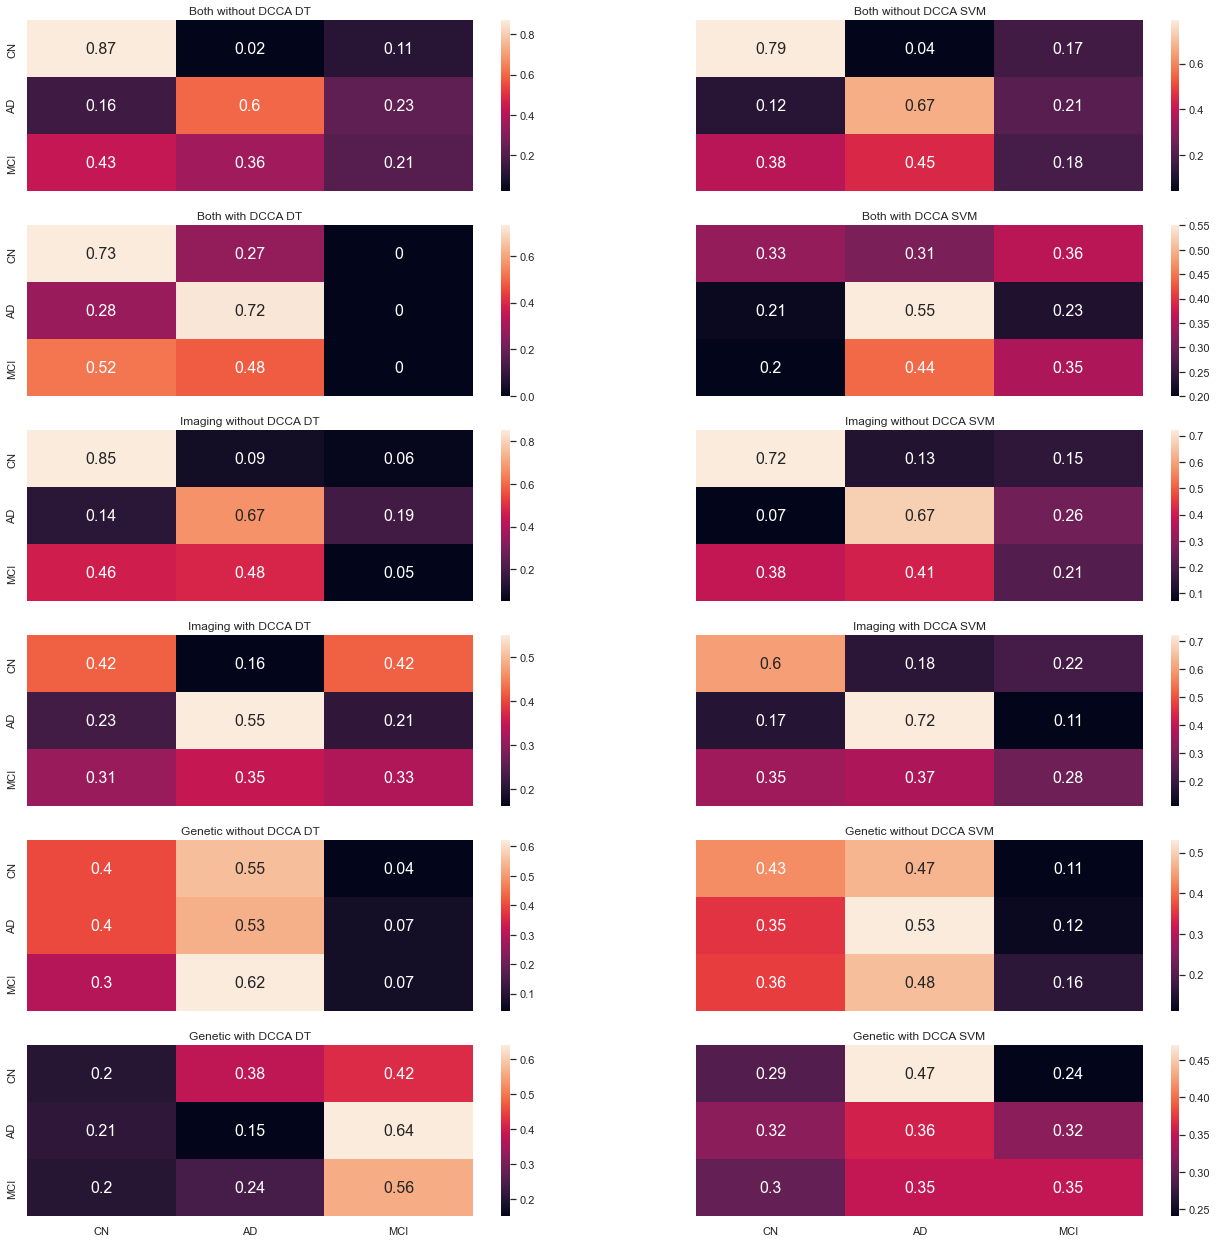

In [14]:
confusion_matrices(Confusion_Matrices, names, n_rows=6, n_cols=2)